## ODE Model
$$\frac{dx}{dt} = a_0 + a_1 \cdot f - Vmax \cdot \frac{x}{K_m + x}$$

## Initialization

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.special import lambertw

MODEL_COLOR_DICT = {'smooth': (0.9, 0.5, 0.9),
                    'pulsing': (0.5, 0.9, 0.9),
                    'numerical': (0.9, 0.9, 0.5)}

MIN_LAG_TIME = 10. # minutes
# the uptake rate will be used to approximate the shape of each pulse
MAX_UPTAKE_RATE = 10. # mmol glc/gCDW/h

Km = 600.  # FtsZ/cell
a0 = 5.4   # FtsZ/cell/min
Vmax = 10. # FtsZ/cell/min
x_initial = 2000. # FtsZ/cell (starting point of 2 hour starvation)
t_starve = 120 # minutes
t_max = 1000
t_max_time_course = 500

# initial value of a1 (only used for plotting first subplot)
# we later fit its value to the data
a1_init = 12 # (FtsZ/cell/min) / (mmol glc/gCDW/h)

# set the range of feedrates to scan
f_max = 1.5

def ftsZ_smooth(a0, a1, f, Vmax, Km, x0, t):
    # x0 is the initial value of ftsZ
    # return a function x(t) where t is the time after x0 was measured

    x_inf = Km * (a0 + a1*f)/(Vmax - a0 - a1*f)
    a = (x0 - x_inf)/(Km + x_inf)
    b = (Vmax - a0 - a1*f)/(Km + x_inf)

    # note that the lambert-W function always has two solutions. When
    # a < -1, we must choose the k = -1 branch, which is the lower
    # branch and when a > -1, we need to choose the k = 0 branch.

    w_val = lambertw(a * np.exp(a - b*t), 0 if (a0 + a1*f) < Vmax else -1).real
    return x_inf + (Km + x_inf) * w_val

def ftsZ_pulsed(a0, a1, f_pulse, t_pulse, t_interval, Vmax, Km, x0, t):
    """
        uses the ftsZ_smooth function in each time interval, to get the final value at time t.
        Assume we start with a pulse
    """
    in_pulse = True
    x = x0

    while True:
        if in_pulse:
            if t <= t_pulse:
                return ftsZ_smooth(a0, a1, f_pulse, Vmax, Km, x, t)
            else:
                x = ftsZ_smooth(a0, a1, f_pulse, Vmax, Km, x, t_pulse)
                t -= t_pulse
                in_pulse = False
        else:
            if t <= t_interval:
                return ftsZ_smooth(a0, a1, 0, Vmax, Km, x, t)
            else:
                x = ftsZ_smooth(a0, a1, 0, Vmax, Km, x, t_interval)
                t -= t_interval
                in_pulse = True

def find_lag_time_numerical(a0, a1, f, Vmax, Km, x0, x1):
    ftsz_dot = lambda x, t: a0 + a1*f - (Vmax * x) / (Km + x)

    t_range = np.linspace(0, t_max, 1000)
    x_int = scipy.integrate.odepack.odeint(ftsz_dot, x_starved, t_range)

    # find the point where the level of FtsZ crosses x0
    if max(x_int) < x_initial: # it never crosses x0
        return np.inf
    return t_range[np.where(x_int > x_initial)[0].min()]

def find_lag_time_smooth(a0, a1, f, Vmax, Km, x0, x1):
    """
        this is the exact analytical solution for the ODE, solved for finding
        the time difference between to values of ftsZ (x0 and x1)
    """
    a = (x1 - x0)/(a0 + a1*f - Vmax)
    b = Km*Vmax/(a0 + a1*f - Vmax)**2
    tmp = 1.0 + ((x1 - x0)*(a0 + a1*f - Vmax))/(x0*(a0 + a1*f - Vmax) + Km*(a0 + a1*f))
    if tmp < 0:
        raise ValueError('infinite lag time')
    return a - b * np.log(tmp)

def find_lag_time_pulsed(a0, a1, f_pulse, t_pulse, t_interval, Vmax,
                         Km, x0, x1):
    x = x0
    t = 0
    while t < t_max:
        x_at_pulse_end = ftsZ_smooth(a0, a1, f_pulse, Vmax, Km, x, t_pulse)
        if x1 < x_at_pulse_end:
            break
        x = ftsZ_smooth(a0, a1, 0, Vmax, Km, x_at_pulse_end, t_interval)
        t += t_pulse + t_interval

    # this pulse is going to cross the finish line (x1), we need
    # to calculate exactly the time when it does using the
    # smooth solution
    return t + find_lag_time_smooth(a0, a1, f_pulse, Vmax, Km, x, x1)

def RMSE_DataFrame(df, x, y, scale='log'):
    if scale == 'log':
        residuals = np.abs(np.log10(df[x]) - np.log10(df[y]))
    else:
        residuals = np.abs(x - y)
    return np.sqrt(np.mean(residuals**2))

def RMSE(a1):
    lag_df = data_df[['lag_time']].copy()

    lag_df['predicted_lag_time'] = 0
    for i, row in data_df.iterrows():
        f = row['feedrate']
        pred_t = find_lag_time_smooth(a0, a1, f, Vmax, Km,
                                      x_starved, x_initial)
        lag_df.at[i, 'predicted_lag_time'] = pred_t

    return RMSE_DataFrame(lag_df, 'lag_time', 'predicted_lag_time')

def plot_data_and_predictions(ax, data_df, lag_time_func, f_critical, linecolor):
    # draw model predictions
    f_range = np.linspace(f_critical+1e-5, f_max, 1000) # mmol glc/gCDW/h
    ax.plot(f_range, list(map(lag_time_func, f_range)),
            '-', label='model', color=linecolor, linewidth=2)

    # draw measured data point
    for system in data_df['system'].unique():
        data_df[data_df['system'] == system].plot(
            ax=ax, x='feedrate', y='lag_time',
            marker='.', label=system, linewidth=0, markersize=10)

    # draw asymptotical line for critical feed-rate
    ax.plot([f_critical, f_critical], ax.get_ylim(), ':',
            color=(0.5, 0.5, 0.5), label=None)
    ax.annotate(r'$f_{critical}$', xy=(f_critical, 20), xytext=(0.5, 15),
                ha='left', va='center', color=(0.4, 0.4, 0.4),
                arrowprops=dict(shrink=0.1, width=1, headwidth=4,
                                facecolor=(0.5, 0.5, 0.5),
                                edgecolor=(0.5, 0.5, 0.5)))

    ax.set_xlim(0, f_max)
    ax.set_ylim(MIN_LAG_TIME*0.9, 1e3)
    ax.set_yscale('log')
    ax.set_xlabel('Feed rate [mmol glc/gCDW/h]')
    ax.set_ylabel('Lag time [min]')
    ax.legend()

## load data

In [2]:
# load measured data from CSV file
data_df = pd.read_excel('summaryinfo.xlsx')

# remove points with 0 lag time (outliers)
data_df.rename(columns={'Calculated TI Feedrate (mmol/g/h)': 'feedrate',
                        'Lag time from fit (min)': 'lag_time',
                        'Pulsing system': 'system',
                        'Pulse Frequency (minutes)': 'freq'}, inplace=True)
data_df = data_df[data_df['lag_time'] > 0]

# real pulsing model
data_df['pulse_length'] = data_df['freq'] * data_df['feedrate'] / MAX_UPTAKE_RATE
data_df['pulse_interval'] = data_df['freq'] - data_df['pulse_length']

# find the value of ftsZ after the 2 hour starvation period
x_starved = ftsZ_smooth(a0, 0, 0, Vmax, Km, x_initial, t_starve)

# Smooth model

## Simulating [FtsZ] over time for selected feedrates

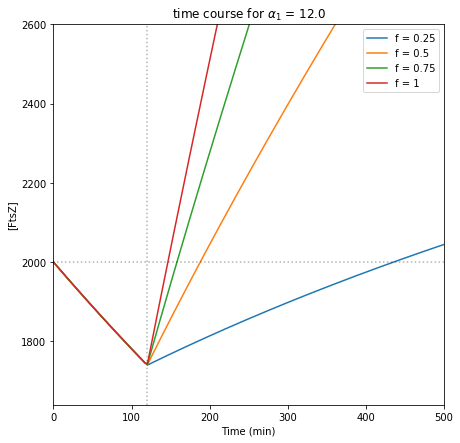

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

# example simulation for a1 = 12 and f = 0.4
for f in [0.25, 0.5, 0.75, 1.0]:
    x_starve = ftsZ_smooth(a0, a1_init, 0, Vmax, Km, x_initial, t_starve)
    f_full = lambda t: ftsZ_smooth(a0, a1_init, 0, Vmax, Km, x_initial, t) \
                         if (t < t_starve) \
                     else \
                         ftsZ_smooth(a0, a1_init, f, Vmax, Km, x_starve, t-t_starve)
    t_range = np.linspace(0, t_max, 300)
    ax.plot(t_range, list(map(f_full, t_range)),
            '-', label='f = %.2g' % f)
ax.legend()
ax.set_xlim(0, t_max_time_course)
ax.set_ylim(x_starved-100, x_initial+600)
ax.set_title(r'time course for $\alpha_1$ = %.1f' % a1_init)
ax.plot([t_starve, t_starve], ax.get_ylim(), 'k:', alpha=0.3)
ax.plot(ax.get_xlim(), [x_initial, x_initial], 'k:', alpha=0.3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('[FtsZ]');

## Fitting the value of $a_1$ to the data points
by minimizing the $r^2$ value between the model lag time and the data (in log scale)


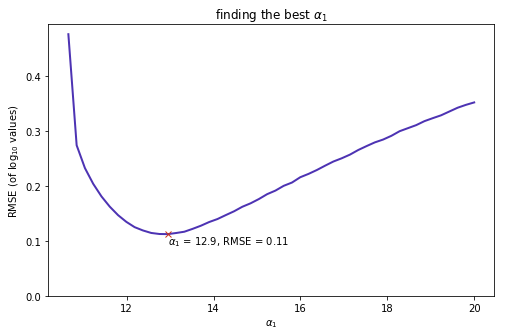

In [4]:
# first, fine the value of a1 under which the lower feedrate would give an
# infinite lag time, therefore we don't need to consider values smaller than
# this.
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
f_min = data_df['feedrate'].min()
a1_min = (1.0/f_min) * (Vmax * x_initial / (Km + x_initial) - a0)

a1_range = np.linspace(a1_min+1e-5, 20, 50)
r2_values = list(map(RMSE, a1_range))
a1 = a1_range[np.argmin(r2_values)]
rmse_max = RMSE(a1)
f_critical = (1.0/a1) * (Vmax * x_initial / (Km + x_initial) - a0)

ax.plot(a1_range, r2_values, '-', color=(0.3, 0.2, 0.7), linewidth=2)
ax.plot(a1, rmse_max, 'x', color=(0.8, 0.2, 0.1))
ax.text(a1, rmse_max, r'$\alpha_1$ = %.1f, RMSE = %.2f' %
        (a1, rmse_max), va='top')
ax.set_xlabel(r'$\alpha_1~ \frac{\text{cell}^{-1}\text{min}^{-1} }{\text{mmol glc/g DCW/h}}$')
ax.set_ylabel(r'RMSE (of $\log_{10}$ values)')
ax.set_ylim(0, None)
ax.set_title(r'finding the best $\alpha_1$');

## Plot predicted and observed lab times (as a function of feed rate), using the fitted $a_1$ value

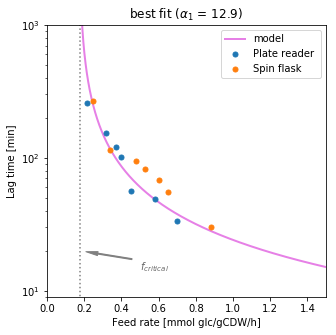

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
t_lag_smooth = lambda f: find_lag_time_smooth(a0, a1, f, Vmax, Km, x_starved, x_initial)
plot_data_and_predictions(ax, data_df, t_lag_smooth, f_critical, MODEL_COLOR_DICT['smooth'])
ax.set_title(r'best fit ($\alpha_1$ = %.1f)' % a1);

# Pusling model

## Simulating [FtsZ] over time for selected feedrates

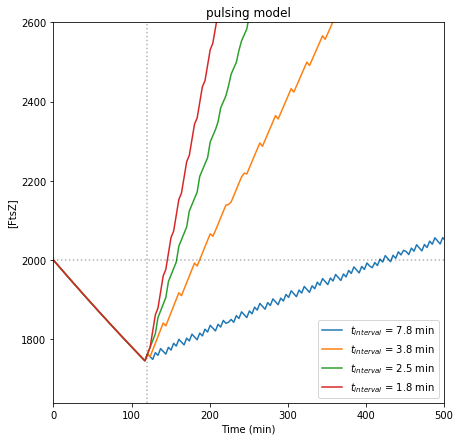

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

x_starve = ftsZ_smooth(a0, a1, 0, Vmax, Km, x_initial, t_starve)
t_pulse = 0.2
for f in [0.25, 0.5, 0.75, 1.0]:
    t_interval = t_pulse * (MAX_UPTAKE_RATE - f) / f
    f_full = lambda t: ftsZ_smooth(a0, a1_init, 0, Vmax, Km, x_initial, t) \
                         if (t < t_starve) \
                     else \
                         ftsZ_pulsed(a0, a1_init, MAX_UPTAKE_RATE, t_pulse, t_interval, Vmax, Km, x_starve, t-t_starve)
    t_range = np.linspace(0, t_max, 300)
    ax.plot(t_range, list(map(f_full, t_range)),
            '-', label=r'$t_{interval}$ = %.2g min' % t_interval)
ax.legend()
ax.set_xlim(0, t_max_time_course)
ax.set_ylim(x_starved-100, x_initial+600)
ax.set_title(r'pulsing model')
ax.plot([t_starve, t_starve], ax.get_ylim(), 'k:', alpha=0.3)
ax.plot(ax.get_xlim(), [x_initial, x_initial], 'k:', alpha=0.3)
ax.set_xlabel('Time (min)')
ax.set_ylabel('[FtsZ]');

## Plot predicted and observed lab times (as a function of feed rate), using the fitted $a_1$ value

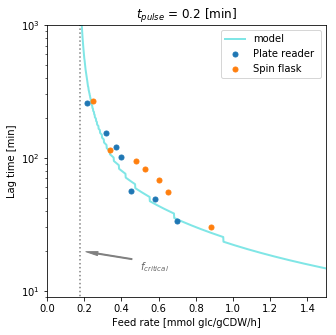

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
t_lag_pulsed = lambda f: find_lag_time_pulsed(a0, a1, MAX_UPTAKE_RATE, t_pulse,
                                              t_pulse * (MAX_UPTAKE_RATE - f) / f,
                                              Vmax, Km, x_starved, x_initial)
plot_data_and_predictions(ax, data_df, t_lag_pulsed, f_critical, MODEL_COLOR_DICT['pulsing'])

ax.set_title(r'$t_{pulse}$ = %.1f [min]' % (t_pulse));

# Compating between the smooth and pulsed models

## compare the two predictions to the observed lag times

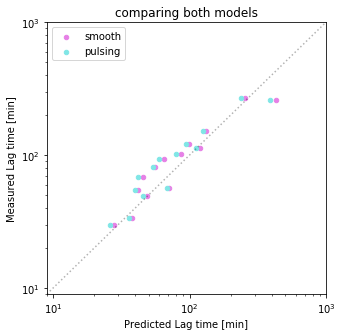

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
validation_df = []
for i, row in data_df.iterrows():
    f = row['feedrate']
    lag_obs = row['lag_time']
    
    lag_smooth = find_lag_time_smooth(a0, a1, f, Vmax, Km, x_starved, x_initial)
    validation_df.append((lag_obs, lag_smooth, 'smooth'))

    t_pulse = row['pulse_length']
    t_interval = row['pulse_interval']
    lag_pulsed = find_lag_time_pulsed(a0, a1, MAX_UPTAKE_RATE, t_pulse,
                                      t_interval, Vmax, Km, x_starved, x_initial)
    validation_df.append((lag_obs, lag_pulsed, 'pulsing'))

validation_df = pd.DataFrame(validation_df,
                             columns=['Measured Lag time [min]',
                                      'Predicted Lag time [min]',
                                      'model'])
for i, model_type in enumerate(validation_df.model.unique()):
    selected_df = validation_df.loc[validation_df.model == model_type, :]  
    rmse = RMSE_DataFrame(selected_df,
                          'Measured Lag time [min]',
                          'Predicted Lag time [min]')
    selected_df.plot.scatter(y='Measured Lag time [min]',
                             x='Predicted Lag time [min]',
                             logx=True, logy=True,
                             color=MODEL_COLOR_DICT[model_type],
                             xlim=(MIN_LAG_TIME*0.9, 1e3),
                             ylim=(MIN_LAG_TIME*0.9, 1e3),
                             ax=ax, label=model_type)
ax.plot([MIN_LAG_TIME*0.9, 1e3], [MIN_LAG_TIME*0.9, 1e3], 'k:', alpha=0.3,
        label=None)
ax.set_title('comparing both models')
ax.legend();

## compare between numberical, analytical (smooth) and analytical (pulsed) models

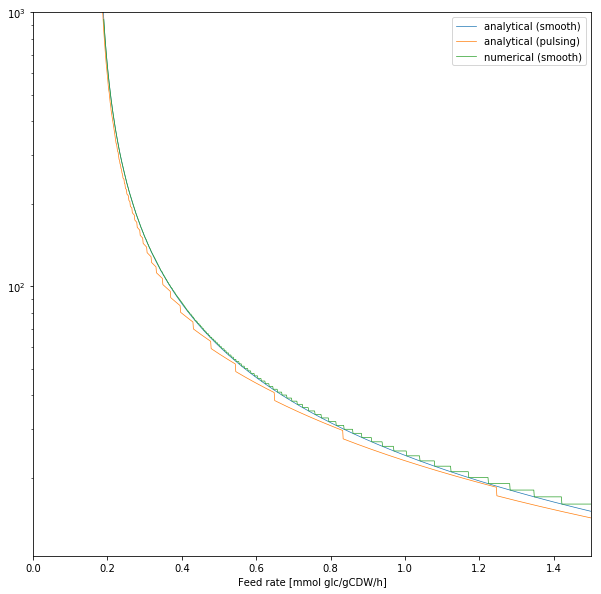

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
t_lag_numerical = lambda f: find_lag_time_numerical(a0, a1, f, Vmax, Km, x_starved, x_initial)
f_range = np.linspace(f_critical+1e-5, f_max, 1000) # mmol glc/gCDW/h


lag_smooth = list(map(t_lag_smooth, f_range))
lag_pulsed = list(map(t_lag_pulsed, f_range))
lag_numerical = list(map(t_lag_numerical, f_range))
lag_df = pd.DataFrame([lag_smooth, lag_pulsed, lag_numerical],
    columns=f_range, index=['analytical (smooth)', 'analytical (pulsing)', 'numerical (smooth)'])
lag_df = lag_df.transpose()
lag_df.index.name = 'Feed rate [mmol glc/gCDW/h]'
lag_df.plot(logy=True, xlim=(0, f_max), ylim=(None, 1e3), ax=ax, linewidth=0.7);

In [10]:
lag_df

,analytical (smooth),analytical (pulsing),numerical (smooth)
Feed rate [mmol glc/gCDW/h],,,
0.177099,8322.722789,1008.095974,inf
0.178423,2925.780572,1010.431088,inf
0.179747,2241.073288,1002.912026,inf
0.181071,1867.193236,1005.247886,inf
0.182396,1618.061677,1007.548076,inf
0.183720,1435.740214,1009.813360,inf
0.185044,1294.663949,1002.509598,inf
0.186368,1181.346076,1004.775532,inf
0.187693,1087.834460,988.209369,inf
